# Pre-processing the data - batch
This notebook follows on from `transform_and_preprocess_spice.ipynb`, so look at that first for an explanation of processing. This notebook has the same processing in fewer commands and in a loop across forecast ref times. Along the way intermediate data is also output, including:
* MOGREPS-G gridded data for UK, all variables in one file.
* MOGREPS-G data for UK in tabular form
* Radar data regridded onto MOGREPS-G grid and summed to 3hr accumualtions, one file
* Radar data on MOGREPS-G grid and summed to 3hr accumualtions in tabular form
* Final output: Merged MOGREPS-G and radar data in tabular

Changing the initial parameter (such as time and location) should allow duplicated o f this notebook to work for other timeperiods.

In [1]:
import pathlib
import datetime
import functools
import os

In [2]:
import numpy

In [3]:
import pandas

In [4]:
import xarray
import iris
import iris.quickplot
import iris.coord_categorisation

In [5]:
import matplotlib.pyplot

# Set parameters for notebook
Set the paths and lists of things to process

In [6]:
project_name = 'precip_rediagnosis'
mogreps_g_name = 'mogreps-g'
ilab_project_dir = pathlib.Path('/project/informatics_lab/')
output_dir =  pathlib.Path('/scratch')/ os.environ['USER'] / project_name

In [7]:
root_data_dir = ilab_project_dir / project_name
mogreps_g_data_dir = root_data_dir / mogreps_g_name
radar_data_dir = root_data_dir / 'radar'

In [8]:
date_fname_template = '{start.year:04d}{start.month:02d}{start.day:02d}T{start.hour:02d}{start.minute:02d}Z_{end.year:04d}{end.month:02d}{end.day:02d}T{end.hour:02d}{end.minute:02d}Z'
fname_extension_grid = '.nc'
fname_extension_tabular = '.csv'
leadtime_template = '{lt:03d}H'
mogreps_g_tab_fname_template = 'prd_mogreps_g_' + leadtime_template + '_' + date_fname_template + fname_extension_tabular
mogreps_g_grid_fname_template = 'prd_mogreps_g_' + leadtime_template + '_' + date_fname_template + fname_extension_grid
radar_tab_fname_template = 'prd_radar_' + date_fname_template + fname_extension_tabular
radar_grid_fname_template = 'prd_radar_' + date_fname_template + fname_extension_grid
output_fname_template = 'prd_merged_' + leadtime_template + '_' + date_fname_template + fname_extension_tabular

In [9]:
variables_single_level = [
    "cloud_amount_of_total_cloud",
    "rainfall_accumulation-PT03H",
    "snowfall_accumulation-PT03H",
    "rainfall_rate",
    "snowfall_rate",
    "height_of_orography",
    "pressure_at_mean_sea_level",
]

variables_height_levels = [
    "cloud_amount_on_height_levels",
    "pressure_on_height_levels",
    "temperature_on_height_levels",
    "relative_humidity_on_height_levels",
    "wind_direction_on_height_levels",
    "wind_speed_on_height_levels",
    
]

In [10]:
num_periods = 10
start_ref_time = datetime.datetime(2020,2,14,12)
forecast_ref_time_range = [start_ref_time + datetime.timedelta(hours=6)*i1 for i1 in range(num_periods)]
leadtime_hours = 15
realizations_list = list(range(35))

In [11]:
dataset = 'mogreps-g'
subset = 'lev1'
forecast_ref_template = '{frt.year:04d}{frt.month:02d}{frt.day:02d}T{frt.hour:02d}00Z.nc.file'
fname_template = '{vt.year:04d}{vt.month:02d}{vt.day:02d}T{vt.hour:02d}00Z-PT{lead_time:04d}H00M-{var_name}.nc'

In [12]:
variables_to_extract = variables_height_levels + variables_single_level

In [13]:
path_lists_vars = {
    var_name: [f1 for f1 in mogreps_g_data_dir.iterdir() if var_name in str(f1)]
    for var_name in variables_to_extract
}


In [14]:
uk_bounds={'latitude':(50,58), 'longitude': (-6,2)}
xarray_select_uk = {k1: slice(*v1) for k1,v1 in uk_bounds.items()}

## Load radar data

In [15]:
radar_days = [datetime.datetime(2020,2,14) + datetime.timedelta(days=d1) for d1 in range(5)]
radar_days

[datetime.datetime(2020, 2, 14, 0, 0),
 datetime.datetime(2020, 2, 15, 0, 0),
 datetime.datetime(2020, 2, 16, 0, 0),
 datetime.datetime(2020, 2, 17, 0, 0),
 datetime.datetime(2020, 2, 18, 0, 0)]

In [16]:
radar_fname_template = 'composite_rainfall_{dt.year:04d}{dt.month:02d}{dt.day:02d}.nc'
radar_cube = iris.cube.CubeList([iris.load_cube(str(radar_data_dir / radar_fname_template.format(dt=dt1))) for dt1 in radar_days] ).concatenate_cube()

In [17]:
iris.coord_categorisation.add_hour(radar_cube, coord='time')
iris.coord_categorisation.add_day_of_year(radar_cube, coord='time')

Load a sample variable from MOGREPS-G to use for regridding radar data.

In [18]:
mogreps_g_example = iris.load_cube(
    str(mogreps_g_data_dir / fname_template.format(
        vt=forecast_ref_time_range[0] + datetime.timedelta(hours=leadtime_hours), 
        lead_time=leadtime_hours, 
        var_name=variables_single_level[0])),
    iris.Constraint(latitude=lambda cell1: uk_bounds['latitude'][0] < cell1 < uk_bounds['latitude'][1], 
                                                     longitude=lambda cell1: uk_bounds['longitude'][0] < cell1 < uk_bounds['longitude'][1], realization=0)
)


Aggregate the instantaneous rates to get an accumulation (this makes the assumption that the rates represent the accumulation for the 5 minute period).

In [19]:
coord_3hr = iris.coords.AuxCoord(radar_cube.coord('hour').points // 3,
                                long_name='3hr',
                                 units='hour',
                                )
radar_cube.add_aux_coord(coord_3hr, data_dims=0)
radar_agg = radar_cube.aggregated_by(['3hr', 'day_of_year'],iris.analysis.SUM)
radar_agg.add_aux_coord(iris.coords.AuxCoord([c1.bound[0] + datetime.timedelta(hours=3) for c1 in radar_agg.coord('time').cells()], long_name='model_accum_time', units='mm/h'), data_dims=0)

When we aggregate the data into 3 hour accumulations, for each hour each sum 12 observations, each of of which are giving us a rainfall rate in mm per hour. Our assumption is that represents the rainfall rate for a 5 minute period (60 minutes divided by 12 observations), so we want to translate this inot how many mm will fall in that 5 minute period. So we need to scale the value by 1/12 to get a 5 minute accumulation, which when aggregate all the 5 minute periods will give us correct 3 hour accumulations.

In [38]:
radar_agg.data = radar_agg.data * (1.0 /12.0)

In [40]:
radar_mggrid = radar_agg.regrid(mogreps_g_example, iris.analysis.Linear())

/home/h01/shaddad/.conda/envs/prd_data_prep/lib/python3.8/site-packages/iris/coord_systems.py:525: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  return ccrs.TransverseMercator(


In [43]:
radar_mggrid

Rainfall Rate Composite (mm/h),time,latitude,longitude
Shape,40,42,28
Dimension coordinates,,,
time,x,-,-
latitude,-,x,-
longitude,-,-,x
Auxiliary coordinates,,,
3hr,x,-,-
day_of_year,x,-,-
forecast_reference_time,x,-,-
hour,x,-,-


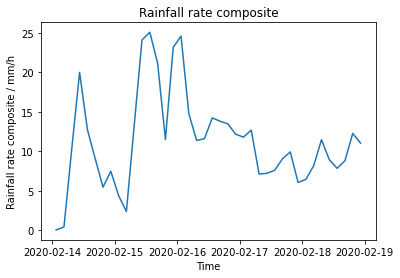

In [44]:
iris.quickplot.plot(radar_mggrid.collapsed(['latitude','longitude'],iris.analysis.MAX))

The plot above shows we have sensible max values for rainfall accumulation after the agrgregation, scaling and regridding.

In [54]:
radar_mggrid.remove_coord('model_accum_time')

In [55]:
radar_mggrid.remove_coord('3hr')

In [56]:
def cftime_to_datetime(input_cft):
    return datetime.datetime(input_cft.year,
                             input_cft.month,
                             input_cft.day,
                             input_cft.hour,
                             input_cft.minute,
                             input_cft.second,
                            )

In [57]:
iris.save(radar_mggrid, 
          str(output_dir / radar_grid_fname_template.format(start=min([cftime_to_datetime(cell1.point) for cell1 in radar_mggrid.coord('time').cells()]),
                                                            end=max([cftime_to_datetime(cell1.point) for cell1 in radar_mggrid.coord('time').cells()])
                                                           )))

In [58]:
radar_acc_regrid_df = xarray.DataArray.from_iris(radar_mggrid).to_dataframe().reset_index()
radar_acc_regrid_df

,time,latitude,longitude,forecast_period,day_of_year,forecast_reference_time,hour,rainfall_rate_composite
0,2020-02-14 01:27:30,50.15625,-5.765625,0,45,2020-02-14 01:27:30,1.0,0.0
1,2020-02-14 01:27:30,50.15625,-5.484375,0,45,2020-02-14 01:27:30,1.0,0.0
2,2020-02-14 01:27:30,50.15625,-5.203125,0,45,2020-02-14 01:27:30,1.0,0.0
3,2020-02-14 01:27:30,50.15625,-4.921875,0,45,2020-02-14 01:27:30,1.0,0.0
4,2020-02-14 01:27:30,50.15625,-4.640625,0,45,2020-02-14 01:27:30,1.0,0.0
...,...,...,...,...,...,...,...,...
47035,2020-02-18 22:27:30,57.84375,0.703125,0,49,2020-02-18 22:27:30,22.0,NaN
47036,2020-02-18 22:27:30,57.84375,0.984375,0,49,2020-02-18 22:27:30,22.0,NaN
47037,2020-02-18 22:27:30,57.84375,1.265625,0,49,2020-02-18 22:27:30,22.0,NaN
47038,2020-02-18 22:27:30,57.84375,1.546875,0,49,2020-02-18 22:27:30,22.0,NaN


In [59]:
radar_acc_regrid_df = radar_acc_regrid_df.rename({'time': 'period_midpoint'}, axis='columns')
radar_acc_regrid_df['time'] = radar_acc_regrid_df['period_midpoint'].apply(lambda dt1: datetime.datetime(dt1.year, dt1.month, dt1.day, dt1.hour, dt1.minute,dt1.second) + datetime.timedelta(hours=1,minutes=32,seconds=30))
radar_acc_regrid_df

,period_midpoint,latitude,longitude,forecast_period,day_of_year,forecast_reference_time,hour,rainfall_rate_composite,time
0,2020-02-14 01:27:30,50.15625,-5.765625,0,45,2020-02-14 01:27:30,1.0,0.0,2020-02-14 03:00:00
1,2020-02-14 01:27:30,50.15625,-5.484375,0,45,2020-02-14 01:27:30,1.0,0.0,2020-02-14 03:00:00
2,2020-02-14 01:27:30,50.15625,-5.203125,0,45,2020-02-14 01:27:30,1.0,0.0,2020-02-14 03:00:00
3,2020-02-14 01:27:30,50.15625,-4.921875,0,45,2020-02-14 01:27:30,1.0,0.0,2020-02-14 03:00:00
4,2020-02-14 01:27:30,50.15625,-4.640625,0,45,2020-02-14 01:27:30,1.0,0.0,2020-02-14 03:00:00
...,...,...,...,...,...,...,...,...,...
47035,2020-02-18 22:27:30,57.84375,0.703125,0,49,2020-02-18 22:27:30,22.0,NaN,2020-02-19 00:00:00
47036,2020-02-18 22:27:30,57.84375,0.984375,0,49,2020-02-18 22:27:30,22.0,NaN,2020-02-19 00:00:00
47037,2020-02-18 22:27:30,57.84375,1.265625,0,49,2020-02-18 22:27:30,22.0,NaN,2020-02-19 00:00:00
47038,2020-02-18 22:27:30,57.84375,1.546875,0,49,2020-02-18 22:27:30,22.0,NaN,2020-02-19 00:00:00


We are not interested in the forecast ref and period from the radar (this doesn't have meaning') so we drop it.

In [81]:
radar_acc_regrid_df = radar_acc_regrid_df.drop(['forecast_reference_time', 'forecast_period'],axis='columns')

In [82]:
radar_acc_regrid_df.to_csv(output_dir / radar_tab_fname_template.format(start=radar_acc_regrid_df['time'].min(),
                                                                        end=radar_acc_regrid_df['time'].min(),
                                                                       ))

## Create a dataset from MOGREPS-G data
Information on Met Office Ensmble forecasts - https://www.metoffice.gov.uk/research/weather/ensemble-forecasting#
Paper - https://www.metoffice.gov.uk/research/weather/ensemble-forecasting 

### Get the mapping of variable names 
Load some files and get the actual variable names.

In [61]:
fcst_ref_time = forecast_ref_time_range[0]
real1 = realizations_list[10]
validity_time = fcst_ref_time + datetime.timedelta(hours=leadtime_hours)

In [62]:
%%time
# load a cube for each variable in iris to get the actual variable name, and populate dictionary mapping from the var name in the file name to the variable as loaded into iris/xarray
file_to_var_mapping = {
    var_file_name: iris.load_cube(str(mogreps_g_data_dir / fname_template.format(vt=validity_time,
                                                                                 lead_time=leadtime_hours,
                                                                                 var_name=var_file_name))).name()
    for var_file_name in variables_single_level + variables_height_levels}
file_to_var_mapping

CPU times: user 665 ms, sys: 59.2 ms, total: 724 ms
Wall time: 1.98 s


{'cloud_amount_of_total_cloud': 'cloud_area_fraction',
 'rainfall_accumulation-PT03H': 'thickness_of_rainfall_amount',
 'snowfall_accumulation-PT03H': 'lwe_thickness_of_snowfall_amount',
 'rainfall_rate': 'rainfall_rate',
 'snowfall_rate': 'lwe_snowfall_rate',
 'height_of_orography': 'surface_altitude',
 'pressure_at_mean_sea_level': 'air_pressure_at_sea_level',
 'cloud_amount_on_height_levels': 'cloud_volume_fraction_in_atmosphere_layer',
 'pressure_on_height_levels': 'air_pressure',
 'temperature_on_height_levels': 'air_temperature',
 'relative_humidity_on_height_levels': 'relative_humidity',
 'wind_direction_on_height_levels': 'wind_from_direction',
 'wind_speed_on_height_levels': 'wind_speed'}

In [63]:
heights = iris.load_cube(str(mogreps_g_data_dir / fname_template.format(vt=validity_time,
                                                                                 lead_time=leadtime_hours,
                                                                                 var_name=variables_height_levels[0]))).coord('height').points

In [64]:
merge_coords = ['latitude', 'longitude', 'time', 'realization']

In [65]:
single_level_var_mappings = {v1: file_to_var_mapping[v1] for v1 in variables_single_level}
height_level_var_mappings = {v1: file_to_var_mapping[v1] for v1 in variables_height_levels}

In [66]:
def load_ds(ds_path, selected_bounds):
    try:
        subset1 = dict(selected_bounds)
        subset1['bnds'] = 0
        single_level_ds = xarray.load_dataset(ds_path).sel(**subset1)
    except KeyError as e1:
        single_level_ds = None
    return single_level_ds

In [67]:
%%time
ts_data_list = []
# gridded_data_list = []
for fcst_ref_time in forecast_ref_time_range:
    print(fcst_ref_time)
    validity_time = fcst_ref_time + datetime.timedelta(hours=leadtime_hours)
    single_level_ds = xarray.merge([load_ds(ds_path= mogreps_g_data_dir / fname_template.format(vt=validity_time,
                                                                                                lead_time=leadtime_hours,
                                                                                                var_name=var1),
                                            selected_bounds=xarray_select_uk,
                                           )
                                    for var1 in variables_single_level]
                                  )
    single_level_df = single_level_ds.to_dataframe().reset_index()

    height_levels_ds = xarray.merge([load_ds(ds_path=mogreps_g_data_dir / fname_template.format(vt=validity_time,
                                                                                                lead_time=leadtime_hours,
                                                                                                var_name=var1),
                                             selected_bounds=xarray_select_uk,
                                            )
                                     for var1 in variables_height_levels])
    hl_df_multirow = height_levels_ds.to_dataframe().reset_index()
    
    var_df_merged = []
    # heights_vars_marged = height_levels_df[height_levels_df.height==heights[0]][ merge_coords]
    for var1 in height_level_var_mappings.values():
        print(var1)
        # for h1 in heights:
        #     heights_vars_marged[f'{var1}_{h1:.1f}'] = list(height_levels_df[height_levels_df.height==h1][var1])
        var_at_heights = [hl_df_multirow[hl_df_multirow.height==h1][merge_coords + [var1]].rename({var1: f'{var1}_{h1:.1f}'}, axis='columns') for h1 in heights]
        var_df_merged += [functools.reduce(lambda x,y: x.merge(y, on=merge_coords), var_at_heights)]
    height_levels_df = functools.reduce(lambda x,y: x.merge(y, on=merge_coords), var_df_merged)    
    
    mogreps_g_single_ts_uk_df = single_level_df.merge(height_levels_df, on=merge_coords)
    mogreps_g_single_ts_uk_df
    
    mogreps_g_single_ts_uk_df = single_level_df.merge(height_levels_df, on=merge_coords)
    ts_data_list += [mogreps_g_single_ts_uk_df]
    ts_mogg_ds1 = xarray.merge([height_levels_ds, single_level_ds])
    ts_mogg_ds1.to_netcdf(output_dir / (
        'prd_mg_ts_'+ f'{validity_time.year:04d}{validity_time.month:02d}{validity_time.day:02d}{validity_time.hour:02d}{validity_time.minute:02d}' 
        + fname_extension_grid)
    )
    # gridded_data_list += [xarray.merge([height_levels_ds, single_level_ds])]

2020-02-14 12:00:00
cloud_volume_fraction_in_atmosphere_layer
air_pressure
air_temperature
relative_humidity
wind_from_direction
wind_speed
2020-02-14 18:00:00
cloud_volume_fraction_in_atmosphere_layer
air_pressure
air_temperature
relative_humidity
wind_from_direction
wind_speed
2020-02-15 00:00:00
cloud_volume_fraction_in_atmosphere_layer
air_pressure
air_temperature
relative_humidity
wind_from_direction
wind_speed
2020-02-15 06:00:00
cloud_volume_fraction_in_atmosphere_layer
air_pressure
air_temperature
relative_humidity
wind_from_direction
wind_speed
2020-02-15 12:00:00
cloud_volume_fraction_in_atmosphere_layer
air_pressure
air_temperature
relative_humidity
wind_from_direction
wind_speed
2020-02-15 18:00:00
cloud_volume_fraction_in_atmosphere_layer
air_pressure
air_temperature
relative_humidity
wind_from_direction
wind_speed
2020-02-16 00:00:00
cloud_volume_fraction_in_atmosphere_layer
air_pressure
air_temperature
relative_humidity
wind_from_direction
wind_speed
2020-02-16 06:00:00


In [68]:
# prd_mogreps_grid_ds = xarray.concat(gridded_data_list)

In [ ]:
# prd_mogreps_grid_ds.to_netcdf(output_dir / mogreps_g_grid_fname_template.format(lt=leadtime_hours,
#                                                                                 start=prd_column_dataset['time'].min(),
#                                                                                 end=prd_column_dataset['time'].max(),
#                                                                                ))

In [69]:
prd_column_dataset = pandas.concat(ts_data_list)


In [70]:
prd_column_dataset

,realization,latitude,longitude,cloud_area_fraction,latitude_longitude,latitude_bnds,longitude_bnds,forecast_period,forecast_reference_time,time,...,wind_speed_2750.0,wind_speed_3000.0,wind_speed_3250.0,wind_speed_3500.0,wind_speed_3750.0,wind_speed_4000.0,wind_speed_4500.0,wind_speed_5000.0,wind_speed_5500.0,wind_speed_6000.0
0,0,50.15625,-5.765625,1.000000,-2147483647,50.0625,-5.90625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,28.9375,29.6250,30.2500,30.5625,30.5625,30.4375,30.6250,33.4375,32.5000,31.9375
1,0,50.15625,-5.484375,1.000000,-2147483647,50.0625,-5.62500,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,28.3125,29.0625,29.8750,30.4375,30.6250,30.4375,30.3125,33.5625,32.4375,31.1250
2,0,50.15625,-5.203125,1.000000,-2147483647,50.0625,-5.34375,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,27.5625,28.3750,29.2500,29.9375,30.1250,29.8750,30.0000,33.6250,32.1250,30.5000
3,0,50.15625,-4.921875,1.000000,-2147483647,50.0625,-5.06250,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,26.6875,27.5000,28.4375,29.1875,29.4375,29.1250,29.6250,33.1875,31.8750,30.2500
4,0,50.15625,-4.640625,1.000000,-2147483647,50.0625,-4.78125,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,26.0625,26.8750,27.7500,28.5000,28.7500,28.3750,29.0625,32.7500,31.6250,30.1875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21163,34,57.84375,0.703125,0.187500,-2147483647,57.7500,0.56250,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,29.1250,29.0000,28.8750,28.7500,28.6250,28.5000,28.7500,29.0625,29.4375,29.8125
21164,34,57.84375,0.984375,0.343750,-2147483647,57.7500,0.84375,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,29.3750,29.1875,29.1250,29.0625,28.9375,28.8125,28.8125,28.8750,28.6250,28.1875
21165,34,57.84375,1.265625,1.000000,-2147483647,57.7500,1.12500,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,29.6875,29.5000,29.4375,29.5000,29.4375,29.3125,29.1250,28.8125,28.0625,26.8125
21166,34,57.84375,1.546875,0.812500,-2147483647,57.7500,1.40625,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,30.0625,29.8750,29.8750,29.9375,30.0000,29.9375,29.5625,28.9375,27.6875,26.0000


In [71]:
prd_column_dataset.to_csv(output_dir / mogreps_g_tab_fname_template.format(lt=leadtime_hours,
                                                                           start=prd_column_dataset['time'].min(),
                                                                           end=prd_column_dataset['time'].max(),
                                                                          ))

## Merging radar and model data
We have now created a table with radar data and a table with MOGREPS-G model data. We  now wantto merge them into a single. The steps are as follows
* trim the time periods so the data covers matching times
* do a merge on latitude, longitude and time. 
  * We don't merge on realization as done for merging the different model fields, as radar is not ensemble data. Instead, the type of merge chosen will insert the radar composite rainfall field for each row with with the correct time and place, so will appear multiple times for each realization present at that timestamp
* Output resulting table to disk.

In [ ]:
prd_column_dataset.time.min(), prd_column_dataset.time.max()

In [75]:
prd_column_dataset.time

0       2020-02-15 03:00:00
1       2020-02-15 03:00:00
2       2020-02-15 03:00:00
3       2020-02-15 03:00:00
4       2020-02-15 03:00:00
                ...        
21163   2020-02-17 09:00:00
21164   2020-02-17 09:00:00
21165   2020-02-17 09:00:00
21166   2020-02-17 09:00:00
21167   2020-02-17 09:00:00
Name: time, Length: 211680, dtype: datetime64[ns]

In [76]:
radar_acc_regrid_df = radar_acc_regrid_df[(radar_acc_regrid_df['time'] >= prd_column_dataset.time.min()) & (radar_acc_regrid_df['time'] <= prd_column_dataset.time.max())]
radar_acc_regrid_df

,period_midpoint,latitude,longitude,forecast_period,day_of_year,forecast_reference_time,hour,rainfall_rate_composite,time
9408,2020-02-15 01:27:30,50.15625,-5.765625,0,46,2020-02-15 01:27:30,1.0,0.004584,2020-02-15 03:00:00
9409,2020-02-15 01:27:30,50.15625,-5.484375,0,46,2020-02-15 01:27:30,1.0,0.041023,2020-02-15 03:00:00
9410,2020-02-15 01:27:30,50.15625,-5.203125,0,46,2020-02-15 01:27:30,1.0,0.182250,2020-02-15 03:00:00
9411,2020-02-15 01:27:30,50.15625,-4.921875,0,46,2020-02-15 01:27:30,1.0,0.393894,2020-02-15 03:00:00
9412,2020-02-15 01:27:30,50.15625,-4.640625,0,46,2020-02-15 01:27:30,1.0,0.179577,2020-02-15 03:00:00
...,...,...,...,...,...,...,...,...,...
31747,2020-02-17 07:27:30,57.84375,0.703125,0,48,2020-02-17 07:27:30,7.0,0.000000,2020-02-17 09:00:00
31748,2020-02-17 07:27:30,57.84375,0.984375,0,48,2020-02-17 07:27:30,7.0,0.000000,2020-02-17 09:00:00
31749,2020-02-17 07:27:30,57.84375,1.265625,0,48,2020-02-17 07:27:30,7.0,0.000000,2020-02-17 09:00:00
31750,2020-02-17 07:27:30,57.84375,1.546875,0,48,2020-02-17 07:27:30,7.0,0.000000,2020-02-17 09:00:00


In [83]:
prd_merged_mogreps_radar = prd_column_dataset.merge(radar_acc_regrid_df, on=['latitude', 'longitude','time'], how='inner')
prd_merged_mogreps_radar

,realization,latitude,longitude,cloud_area_fraction,latitude_longitude,latitude_bnds,longitude_bnds,forecast_period,forecast_reference_time,time,...,wind_speed_3750.0,wind_speed_4000.0,wind_speed_4500.0,wind_speed_5000.0,wind_speed_5500.0,wind_speed_6000.0,period_midpoint,day_of_year,hour,rainfall_rate_composite
0,0,50.15625,-5.765625,1.000000,-2147483647,50.0625,-5.90625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,30.5625,30.4375,30.6250,33.4375,32.5000,31.9375,2020-02-15 01:27:30,46,1.0,0.004584
1,1,50.15625,-5.765625,1.000000,-2147483647,50.0625,-5.90625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,29.2500,29.8750,29.2500,31.1250,33.5000,34.5000,2020-02-15 01:27:30,46,1.0,0.004584
2,2,50.15625,-5.765625,1.000000,-2147483647,50.0625,-5.90625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,30.1250,30.5625,31.5625,37.0000,36.6875,33.5625,2020-02-15 01:27:30,46,1.0,0.004584
3,3,50.15625,-5.765625,1.000000,-2147483647,50.0625,-5.90625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,28.8750,28.9375,30.3125,34.5000,34.0625,33.0625,2020-02-15 01:27:30,46,1.0,0.004584
4,4,50.15625,-5.765625,1.000000,-2147483647,50.0625,-5.90625,0 days 15:00:00,2020-02-14 12:00:00,2020-02-15 03:00:00,...,29.9375,30.3750,31.1250,34.4375,33.8125,33.2500,2020-02-15 01:27:30,46,1.0,0.004584
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211675,30,57.84375,1.828125,0.062500,-2147483647,57.7500,1.68750,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,33.4375,33.3750,33.0000,32.0625,30.8750,29.9375,2020-02-17 07:27:30,48,7.0,0.000000
211676,31,57.84375,1.828125,0.484375,-2147483647,57.7500,1.68750,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,28.5625,28.6250,29.2500,29.8125,29.6250,29.3125,2020-02-17 07:27:30,48,7.0,0.000000
211677,32,57.84375,1.828125,0.000000,-2147483647,57.7500,1.68750,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,29.9375,29.8750,30.1875,30.6250,31.0625,31.1250,2020-02-17 07:27:30,48,7.0,0.000000
211678,33,57.84375,1.828125,0.359375,-2147483647,57.7500,1.68750,0 days 15:00:00,2020-02-16 18:00:00,2020-02-17 09:00:00,...,33.5000,33.8125,34.4375,35.0625,35.1250,34.9375,2020-02-17 07:27:30,48,7.0,0.000000


Looking at the results of the merge, we see that we have different values for model output for different realisations at the same time and location, but all of those datapoints will have the same value for radar rainfall accumulation.

In [84]:
prd_merged_mogreps_radar[(prd_merged_mogreps_radar['time'] == '2020-02-16T015:00') &
                         (prd_merged_mogreps_radar['latitude'] == 50.15625) &
                         (prd_merged_mogreps_radar['longitude'] == -5.765625) 
                        ][['latitude','longitude','realization', 'time','air_temperature_5.0','rainfall_rate_composite']]

,latitude,longitude,realization,time,air_temperature_5.0,rainfall_rate_composite
127008,50.15625,-5.765625,0,2020-02-16 15:00:00,282.9375,0.566035
127009,50.15625,-5.765625,1,2020-02-16 15:00:00,282.8125,0.566035
127010,50.15625,-5.765625,2,2020-02-16 15:00:00,283.1875,0.566035
127011,50.15625,-5.765625,3,2020-02-16 15:00:00,283.1250,0.566035
127012,50.15625,-5.765625,4,2020-02-16 15:00:00,282.3750,0.566035
127013,50.15625,-5.765625,5,2020-02-16 15:00:00,283.0000,0.566035
127014,50.15625,-5.765625,6,2020-02-16 15:00:00,282.8750,0.566035
127015,50.15625,-5.765625,7,2020-02-16 15:00:00,282.8125,0.566035
127016,50.15625,-5.765625,8,2020-02-16 15:00:00,282.5000,0.566035
127017,50.15625,-5.765625,9,2020-02-16 15:00:00,283.6250,0.566035


### Output to Tabular data format

In [85]:
start_dt = prd_merged_mogreps_radar['time'].min()
end_dt = prd_merged_mogreps_radar['time'].max()

In [86]:
output_fname = output_fname_template.format(lt=leadtime_hours,
                                            start=start_dt,
                                            end=end_dt,
                                           )
output_path = output_dir / output_fname
print(output_path)
prd_merged_mogreps_radar.to_csv(output_path)

/scratch/shaddad/precip_rediagnosis/prd_merged_015H_20200215T0300Z_20200217T0900Z.csv


In [ ]:
#TODO:add parquet to conda environment and save as parquet format
#prd_merged_mogreps_radar.to_parquet(output_path)